*Copyright (c) Microsoft Corporation. All rights reserved.*                 
*Licensed under the MIT License.*

In [18]:
%matplotlib inline

# Interpreting Bag of Words Text Classification models

This notebook show a set by step implementation of traditional machine algorithms with a bag of words representation as an interpretable model using feature importances.

###### Note:
* This example walks through a logistic regression baseline with a simple Bag of Words encoding. However, any model that follows sklearn's classifier API should be supported natively or with minimal tweaking.
* The interpreter supports interpretations using either coefficients associated with linear models or feature importances associated with ensemble models.
* For larger text datasets, the classifier relies on scipy's sparse representations to keep the dataset in memory.

In [19]:
#import libraries
import sys
import os
import json
import pandas as pd
import numpy as np
import scipy
import string
from scrapbook.api import glue
working_dir = %pwd
sys.path.append(os.path.dirname(os.path.dirname(working_dir))) # TODO : explore methods to eliminate
from utils_interpret.utils_bow import SpacyTokenizer,encode_labels
from utils_interpret.utils_bow import plot_local_imp, get_local_importances
from utils_interpret.utils_bow import get_important_words, plot_global_imp
# sklearn
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# spacy and nlp recipes
import spacy
from spacy.lang.en import English
from utils_nlp.dataset.multinli import load_pandas_df

## Introduction

The notebook is built on features made available by [Sci-kit Learn](https://scikit-learn.org/stable/) and [spacy](https://spacy.io/) for easier compatibiltiy with popular tookits.                     
The notebook also relies on the pip installable "utils_nlp.dataset.multinli" package from Microsoft's [NLP-recipes](https://github.com/microsoft/nlp-recipes/tree/master/utils_nlp) open source package for dataloading purposes.               


### An Overview

The [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) allows a 1:1 mapping from the individual words to their respective frequencies in the Document-term matrix.                                
We use spacy's medium language [model](https://spacy.io/models/en#en_core_web_md) that's trained on common crawl for text preprocessing.

Set configuration parameters

In [20]:
#SPACY_LANG_MODEL = 'en_core_web_md'
DATA_FOLDER = './temp'
TRAIN_SIZE = 0.7
TEST_SIZE = 0.3

Load data

In [21]:
df = load_pandas_df(DATA_FOLDER, "train")
df = df[df["gold_label"]=="neutral"]  # get unique sentences

# fetch documents and labels from data frame
X_str = df['sentence1'] # the document we want to analyze
ylabels = df['genre'] # the labels, or answers, we want to test against

## Configure preprocessessing setup
Each text document in the dataset under goes the following preprocessing steps during conversion into tokens:
* Use spacy's English parser to parse document.
* Convert to lower case.
* Strip off white space surrounding each word.
* [lemmatize](https://en.wikipedia.org/wiki/Lemmatisation) based on spacy's language model.
* Remove stop words and punctuation to obtain tokens.

## Preprocess training data and labels and cast into correct format
* Count tokens and construct sparse term document matrix.
* Vectorize tokens into counts.
* Convert labels from strings into integers.

###### Note: Vocabulary

* *The vocabulary is compiled from the dataset. This means that any word that does not appear in the Dataset is not a part of the vocabulary. This also means that the vocabulary varies with the dataset.*           
* *Every word that appear one or more times is considered to be part of the vocab.*
* *However, The sklearn countvectorizer allows addition of a custom vocabulary as an input parameter.*

In [22]:
# Convert tokens to BOW count vector
spacytokenizer = SpacyTokenizer(English())
countvectorizer = CountVectorizer(tokenizer = spacytokenizer.tokenize, ngram_range=(1,1))
X_vec = countvectorizer.fit_transform(X_str)

# Encode labels as numbers
labelencoder, ylabels = encode_labels(ylabels)

C:\Users\anpimple\AppData\Local\Continuum\anaconda3\envs\interpret_env\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Configure training setup

* Split data into train and test using a random shuffle
* load desired classifier. In this case, Logistic Regression.
* Setup grid search for hyperparameter optimization and train model. Edit the hyper parameter range to search over as per your model.
* Fit models to train set

In [23]:
# Split into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X_vec,ylabels, train_size = TRAIN_SIZE, 
                                                    test_size = TEST_SIZE, random_state=0)
print("X_train shape =" + str(X_train.shape))
print("y_train shape =" + str(y_train.shape))
print("X_train data structure = "+ str(type(X_train)))

X_train shape =(91630, 49721)
y_train shape =(91630,)
X_train data structure = <class 'scipy.sparse.csr.csr_matrix'>


###### Note:
* *Set the parameters using cross-validation*
* *Below listed hyperparamters are selected by searching over a larger space.*
* *These apply speciically to this instance of the logistic regression model and mnli dataset.*
* *'Multinomial' setup was found to be better than 'one-vs-all' across the board*
* default 'liblinear' solver is not supported for 'multinomial' model setup
* *For a different model or dataset, set the range as appropriate*

In [24]:
tuned_parameters = [{'solver': ['saga'],'multi_class': ['multinomial'], 'C': [10**4]}]

model =  LogisticRegression()
classifier_CV = GridSearchCV(model, tuned_parameters, cv=3, scoring='accuracy')
classifier_CV.fit(X_train,y_train)

C:\Users\anpimple\AppData\Local\Continuum\anaconda3\envs\interpret_env\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [10000], 'multi_class': ['multinomial'],
                          'solver': ['saga']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

## Results
* Obtain best model and corresponding hyper parameters
* Report Accuracy, F1 score, Precision and Recall.

In [25]:
# obtain best classifier and hyper params
classifier = classifier_CV.best_estimator_
print("best classifier: " + str(classifier_CV.best_params_))

best classifier: {'C': 10000, 'multi_class': 'multinomial', 'solver': 'saga'}


Report performance metrics

In [26]:
mean_accuracy = classifier.score(X_test, y_test, sample_weight=None)
print("accuracy = " + str(mean_accuracy*100) + "%")
y_pred = classifier.predict(X_test)
[precision, recall, fscore, support] = precision_recall_fscore_support(y_test, y_pred,average='macro')

accuracy = 83.61089890501655%


Capture metrics for integration testing

In [14]:
glue("accuracy", mean_accuracy)
glue("precision", precision)
glue("recall", recall)
glue("f1", fscore)
print ("[precision, recall, fscore, support] = " + str([precision, recall, fscore, support]))

[precision, recall, fscore, support] = [0.8388769725719168, 0.8355047103125519, 0.8360375338609657, None]


## Compute global importances

Visualize the most and least important words for each class over the entire dataset
Choose which label's importances to visualize 

The class names are as follows
['fiction' 'government' 'slate' 'telephone' 'travel']


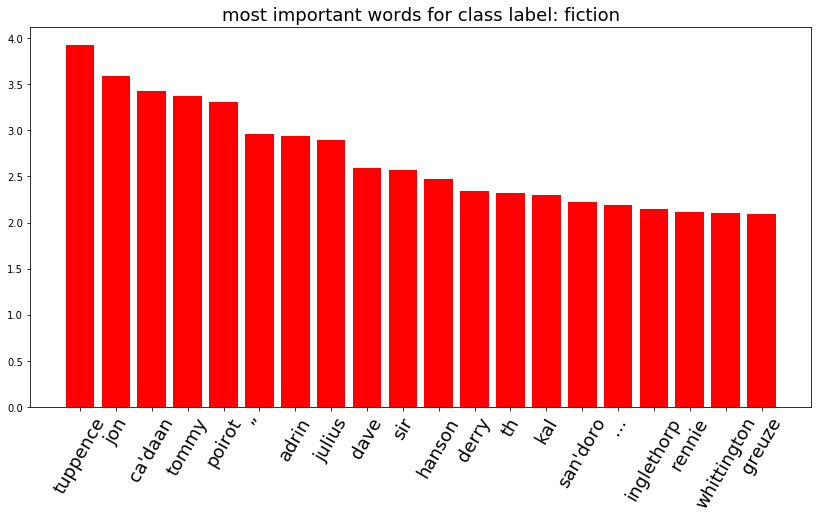

In [15]:
print("The class names are as follows")
print(labelencoder.classes_)
label_name = "fiction"

#Obtain the top feature ids for the selected class label.           
#Map top features back to words.
top_words, top_importances = get_important_words(classifier, label_name, countvectorizer, labelencoder)
#Plot the feature importances
plot_global_imp(top_words, top_importances, label_name)

## Compute local importances

In [16]:
#Enter any document & label pair that needs to be interpreted
document = "I travelled to the beach. I took the train. I saw faries, dragons and elves"
label_name = "travel"

#Obtain the top feature ids for the selected class label
parsed_sentence, word_importances = get_local_importances(classifier, labelencoder, label_name,
                                                          document, spacytokenizer, countvectorizer)
#Visualize local feature importances as a heatmap over words in the document
plot_local_imp(parsed_sentence, word_importances)